In [1]:
%load_ext autoreload
%autoreload 2

import time
from functools import partial

import network
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

Echter code befindet sich in ex2b.py. Jupyter verträgt sich nicht mit multiprocessing. Daher nur plotten der Ergebnissse hier.

In [18]:
a = 0 # value to check if min_p was too high

# finds smallest p where a grid of size L perculates
def calc_pc_once(L, min_p, step):
    p = min_p
    while True:
        n = network.Network(int(L), int(L), p)
        n.hoshen_kopelman()
        if n.is_percolating():
            if p < min_p + step:
                global a
                a += 1
            return p
        p += step

# finds smallest p where a grid of size L perculates with multiple runs and averaging the result
def calc_pc(L, min_p=0.50, step=0.01, amount=50):
    pcs = np.zeros(amount)
    for i in range(amount):
        pcs[i] = calc_pc_once(L, min_p, step)
    return np.average(pcs[pcs > 0])

# finds smallest p where a grid of size L perculates with multiple runs running parallel and averaging the result
def calc_pc_multiproc(L, min_p=0.50, step=0.01, amount=50):
    args = np.full(amount, L, dtype=np.int32)
    with Pool(processes=20) as pool:
        pcs = np.array(pool.map(partial(calc_pc_once, min_p=min_p, step=step), args))
    print(pcs)
    return np.average(pcs[pcs > 0])

def do_ex(L, min_p=0.50, step=0.01, amount=50):
    t = time.perf_counter()
    pc = calc_pc_multiproc(L, min_p, step, amount)
    print(f'Size {L} took {time.perf_counter() - t} seconds')
    return pc

Bei Berechnung in eins ist wenig Kontrolle über einzelne $L$. Einzeln berechnen und Ergebnis in Array eintragen ist vorteilhafter.

Bei 20 Prozessen kommt es ab $L=2^{13}$ zu Arbeitsspeicher Problemen. Durch Verringerung auf 10 Prozesse konnte $p_c$ in etwa 30 Min. berechnet werden.
$L=2^{14}$ könnte Schätzungsweise in 1 bis 2 h berechnet werden, Auflösung müsste aber kleiner gewählt werden für aussagekräftiges Ergebnis.
 
Ergebniss: $\lim_{L\rightarrow\infty} p_c \approx 60\%$

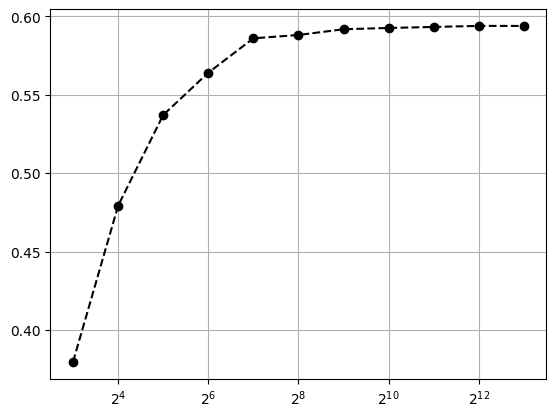

In [ ]:
L = 2 ** np.array(range(3, 13 + 1))
pc = [0.37968, 0.47916, 0.53696, 0.56392, 0.58584, 0.58796, 0.5916, 0.59244, 0.59308, 0.59376, 0.59372]
#print(do_ex(2**3, min_p=0.20, step=0.002, amount=50)) # 0.37968
#print(do_ex(2**4, min_p=0.30, step=0.002, amount=50)) # 0.47916
#print(do_ex(2**5, min_p=0.40, step=0.002, amount=50)) # 0.53696
#print(do_ex(2**6, min_p=0.50, step=0.002, amount=50)) # 0.56392
#print(do_ex(2**7, min_p=0.580, step=0.002, amount=50)) # 0.58584
#print(do_ex(2**8, min_p=0.580, step=0.002, amount=50)) # 0.58796 # 3.7s
#print(do_ex(2**9, min_p=0.584, step=0.002, amount=50)) # 0.5916 # 10.8s
#print(do_ex(2**10, min_p=0.586, step=0.002, amount=50)) # 0.59244 # 32.9s
#print(do_ex(2**11, min_p=0.588, step=0.002, amount=50)) # 0.59308 # 109.3s
#print(do_ex(2**12, min_p=0.588, step=0.002, amount=50)) # 0.59376 # 472.9s
#print(do_ex(2**13, min_p=0.590, step=0.002, amount=50)) # 0.59372 # 1895.9s with 10 processes
#print(do_ex(2**14, min_p=0.55, step=0.01, amount=5)) #

fig, ax = plt.subplots()
ax.plot(L, pc, 'ok--')
ax.set_xscale('log', base=2)
plt.grid(True)